In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\dorasir\anaconda3\envs\net-simu\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [6]:
import numpy as np
import os
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd
from utils.transformation import clr_transform, alr_transform
from matplotlib import pyplot as plt
from itertools import product
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from utils import simulation
import rpy2.robjects as robjects
import seaborn as sns
from utils.generalized_lotka_volterra import GeneralizedLotkaVolterra
from utils.compositional_lotka_volterra import CompositionalLotkaVolterra
from scipy.stats import ttest_rel
import utils.evaluations as ev
from utils.evaluations import correlation_score, precision_matrix_score, clv_score, glv_score, pcor_score, sparcc_score, speic_score
from typing import List
import seaborn as sns
from utils.transformation import clr_transform, alr_transform


metrics = [average_precision_score, roc_auc_score]
os.chdir('d:\\microbial_network\\microbial_network_explore')

In [3]:
n_vertices = 50
avg_degree = 5

time_points = 100
time_step = 0.01
downsample = 1
noise_var = 1e-3
scale_simulation = 100

# No noise simulation

In [5]:
network_type = 'random'
# network_type = 'small-world'

interaction_type = 'random'

adj, M = simulation.gen_graph(n_vertices, avg_degree, network_type=network_type, interaction_type=interaction_type)

In [6]:
vs = [25, 50, 100]
ds = [2, 5, 10]
ns = ['random', 'small-world', 'scale-free']

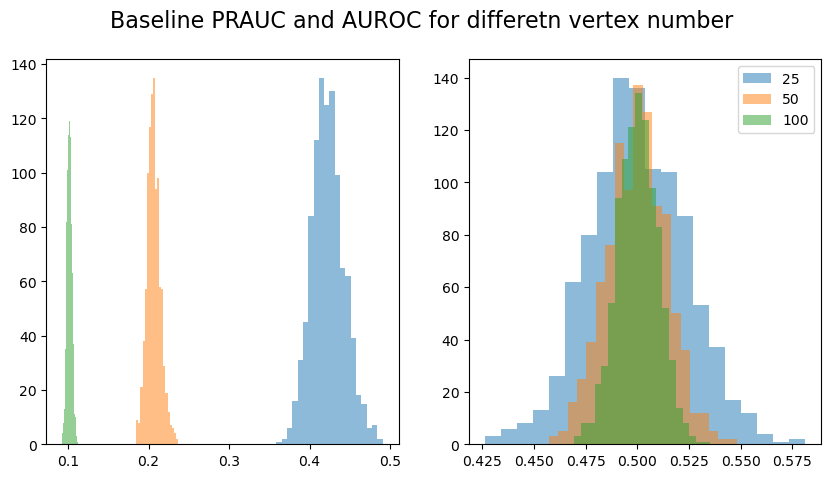

In [8]:
# Compare the response of PRAUC and AUROC to the number of vertices
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for v in vs:
    baseline_pr = []
    baseline_auc = []
    repeat = 1000
    adj, M = simulation.gen_graph(v, 10, network_type='random', interaction_type='random')
    for _ in range(repeat):
        baseline = np.random.uniform(0, 1, size=(v, v))
        baseline_pr.append(average_precision_score(adj[~np.eye(v, dtype=bool)], baseline[~np.eye(v, dtype=bool)]))
        baseline_auc.append(roc_auc_score(adj[~np.eye(v, dtype=bool)], baseline[~np.eye(v, dtype=bool)]))
    n, bins, _ = ax[0].hist(baseline_pr, bins=20, alpha=0.5, label=f'{v}')
    n, bins, _ = ax[1].hist(baseline_auc, bins=20, alpha=0.5, label=f'{v}')
    # Set title for the entire figure
    fig.suptitle('Baseline PRAUC and AUROC for different vertex number', fontsize=16)
plt.legend()
plt.savefig('docs/plots/baseline.png', dpi=300)

PRAUC: 0.105 +- 0.007
AUROC: 0.500 +- 0.020


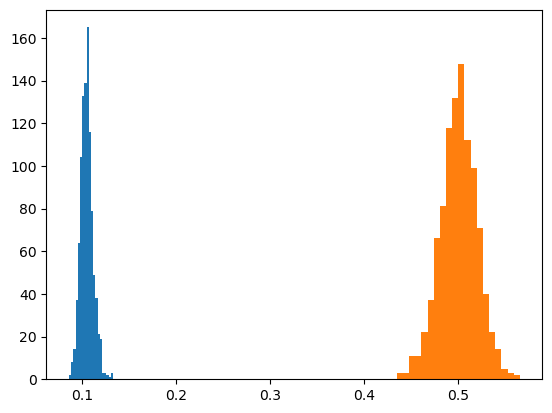

In [6]:
baseline_pr = []
baseline_auc = []
repeat = 1000
for _ in range(repeat):
    # baseline = np.mean(np.dstack([np.random.uniform(0, 1, size=(n_vertices, n_vertices)) for _ in range(repeat)]), axis=2)
    # baseline_score = average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], baseline[~np.eye(n_vertices, dtype=bool)])
    # baseline_scores.append(baseline_score)
    baseline = np.random.uniform(0, 1, size=(n_vertices, n_vertices))
    baseline_pr.append(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], baseline[~np.eye(n_vertices, dtype=bool)]))
    baseline_auc.append(roc_auc_score(adj[~np.eye(n_vertices, dtype=bool)], baseline[~np.eye(n_vertices, dtype=bool)]))
n, bins, _ = plt.hist(baseline_pr, bins=20)
mu = np.mean(baseline_pr)
sigma = np.std(baseline_pr)
print(f'PRAUC: {mu:.3f} +- {sigma:.3f}')

n, bins, _ = plt.hist(baseline_auc, bins=20)
mu = np.mean(baseline_auc)
sigma = np.std(baseline_auc)
print(f'AUROC: {mu:.3f} +- {sigma:.3f}')

## Simulation result on single simulation

In [8]:
# Simulate data
abd, _, _ = simulation.simulate_noiseless_glv(time_points=time_points, downsample=downsample, adj=adj, M=M)
abd_df = pd.DataFrame(abd)
ev.correlation_score(abd_df, adj, metrics=metrics, verbose=True)
ev.precision_matrix_score(abd_df, adj, metrics=metrics, verbose=True)
abd_clr = pd.DataFrame(clr_transform(abd_df))

ev.correlation_score(abd_clr, adj, metrics=metrics, verbose=True)
ev.precision_matrix_score(abd_clr, adj, metrics=metrics, verbose=True)
ev.clv_score(abd, adj, metrics=metrics, verbose=True)
ev.glv_score(abd, adj, metrics=metrics, verbose=True)

In [21]:
%%R -i abd_df -i abd
library(ppcor)
library(SpiecEasi)
network_pred_ppea <- abs(pcor(abd)$estimate)
network_pred_sparcc <- abs(sparcc(abd)$Cor)
network_pred_spiec <- spiec.easi(abd,method='mb')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done



In [23]:
print('Partial Pearson')
network_pred_ppea = robjects.globalenv['network_pred_ppea']
network_pred_ppea = np.array(network_pred_ppea)
ev.calc_nondiag_score(network_pred_ppea, adj, metrics=metrics, verbose=True)

print('SparCC')
network_pred_sparcc = robjects.globalenv['network_pred_sparcc']
network_pred_sparcc = np.array(network_pred_sparcc)
ev.calc_nondiag_score(network_pred_sparcc, adj, metrics=metrics, verbose=True)

print('SpiecEasi')
network_pred_spiec = robjects.globalenv['network_pred_spiec']
network_pred_spiec = np.array(network_pred_spiec)
ev.calc_nondiag_score(network_pred_spiec, adj, metrics=metrics, verbose=True)

Partial Pearson
average_precision_score: 0.10126341131477266
roc_auc_score: 0.4984945454545455
SparCC
average_precision_score: 0.12137298576718401
roc_auc_score: 0.5482109090909091
SpiecEasi
average_precision_score: 0.10204081632653061
roc_auc_score: 0.4990909090909091


[0.10204081632653061, 0.4990909090909091]

# Simulation with MiSDEED

In [9]:
z, x, abundance, _, _ = simulation.simulate_glv(time_points=time_points, time_step=time_step, downsample=downsample, adj=adj, M=M, noise_var=s)
abd_df = pd.DataFrame(abd)
abd_clr = pd.DataFrame(clr_transform(abd))
pearson_scores = ev.correlation_score(abd_df, adj, metrics=metrics, verbose=True)
precision_scores = ev.precision_matrix_score(abd_df, adj, metrics=metrics, verbose=True)
clr_pearson_scores = ev.correlation_score(abd_clr, adj, metrics=metrics, verbose=True)
clr_precision_scores = ev.precision_matrix_score(abd_clr, adj, metrics=metrics, verbose=True)
clv_scores = ev.clv_score(abd, adj, metrics=metrics, verbose=True)
glv_scores = ev.glv_score(abd, adj, metrics=metrics, verbose=True)

NameError: name 'abd' is not defined

In [17]:
%%R -i abd_df -i abd
library(ppcor)
library(SpiecEasi)
network_pred_ppea <- abs(pcor(abd_df)$estimate)
network_pred_sparcc <- abs(sparcc(abd)$Cor)
network_pred_spiec <- spiec.easi(abd,method='mb')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: 载入需要的程辑包：MASS

R[write to console]: 
载入程辑包：'SpiecEasi'


R[write to console]: The following object is masked from 'package:MASS':

    fitdistr


R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done



In [18]:
print('Partial Pearson')
network_pred_ppea = robjects.globalenv['network_pred_ppea']
network_pred_ppea = np.array(network_pred_ppea)
ev.calc_nondiag_score(network_pred_ppea, adj, metrics=metrics, verbose=True)

print('SparCC')
network_pred_sparcc = robjects.globalenv['network_pred_sparcc']
network_pred_sparcc = np.array(network_pred_sparcc)
ev.calc_nondiag_score(network_pred_sparcc, adj, metrics=metrics, verbose=True)

print('SpiecEasi')
network_pred_spiec = robjects.globalenv['network_pred_spiec']
network_pred_spiec = np.array(network_pred_spiec)
ev.calc_nondiag_score(network_pred_spiec, adj, metrics=metrics, verbose=True)

Partial Pearson
average_precision_score: 0.10126341131477266
roc_auc_score: 0.4984945454545455
SparCC
average_precision_score: 0.10191808017185519
roc_auc_score: 0.47928000000000004
SpiecEasi
average_precision_score: 0.10204081632653061
roc_auc_score: 0.4990909090909091


[0.10204081632653061, 0.4990909090909091]

In [19]:
%%R -i abd
network_pred_spiec <- spiec.easi(abd,method='glasso')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with glasso...

R[write to console]: done



In [20]:
network_pred_spiec = robjects.globalenv['network_pred_spiec']
network_pred_spiec = np.array(network_pred_spiec)
print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_spiec[~np.eye(n_vertices, dtype=bool)]))
print(roc_auc_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_spiec[~np.eye(n_vertices, dtype=bool)]))

0.11129543235382458
0.5378945454545454


In [17]:
a = ev.speic_score(abd, adj, metrics=metrics, verbose=True)

R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done



average_precision_score: 0.10027708234662198
roc_auc_score: 0.4867236363636364


## Simulation of noiseless data from MiSDEED

In [15]:
# Set up parameters
n_vertices = 50
avg_degree = 5
network_type = 'random'
interaction_type = 'random'
time_points = 1000
# time_step = 0.05
time_step = 1e-2
downsample = 1
noise_var = 1e-3

evaluation_func = [correlation_score, precision_matrix_score, clv_score, glv_score, pcor_score, sparcc_score, speic_score]
metrics = [average_precision_score, roc_auc_score]

In [11]:
# Define function for evaluation
def evaluation(adj, abundance, evaluation_func, metrics=average_precision_score, verbose=False):
    scores = []
    for func in evaluation_func:
        scores.append([func._method, *func(abundance, adj, metrics=metrics, verbose=verbose)])
    columns = ['Method']
    columns.extend([metric.__name__ for metric in metrics] if isinstance(metrics, List) else [metrics.__name__])
    scores_df = pd.DataFrame(scores, columns=columns)
    return scores_df

First we explore the effect of the number of timepoints on absolute abundance

In [22]:
%%capture
result_df = pd.DataFrame(columns=['Method', 'average_precision_score', 'roc_auc_score', 'time_points'])
var_time_points = [100, 1000, 5000, 10000]
for t in var_time_points:
    z, x, abd, adj, M = simulation.simulate_glv(num_taxa = n_vertices, avg_degree=avg_degree, time_points=t, time_step=time_step, downsample=1, noise_var=0)
    score_df = evaluation(adj, z, evaluation_func, metrics=metrics, verbose=False)
    score_df['time_points'] = t
    result_df = result_df.append(score_df, ignore_index=True)

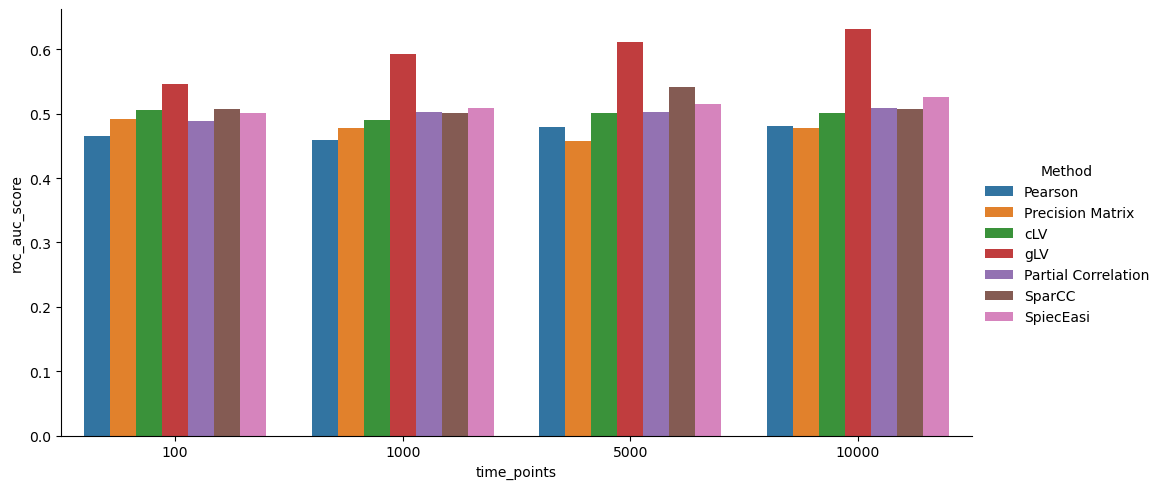

In [24]:
sns.catplot(data=result_df, x='time_points', y='roc_auc_score', hue='Method', kind='bar', height=5, aspect=2)
plt.savefig('docs/plots/timepoints_roc_auc_score.png')

Then we check the effect of maximal interaction strength, note that we are only changing the max possible number, the actual strength follows a uniform distribution between -max to max.

In [27]:
%%capture
var_for_test = 'interaction_strength'
result_df = pd.DataFrame(columns=['Method', 'average_precision_score', 'roc_auc_score', var_for_test])
var_strength = [0.1, 0.5, 1]
for strength in var_strength:
    z, x, abd, adj, M = simulation.simulate_glv(num_taxa = n_vertices, avg_degree=avg_degree, max_interaction_strength=strength, time_points=1000, time_step=1e-2, downsample=1, noise_var=0)
    score_df = evaluation(adj, z, evaluation_func, metrics=metrics, verbose=False)
    score_df[var_for_test] = strength
    result_df = result_df.append(score_df, ignore_index=True)

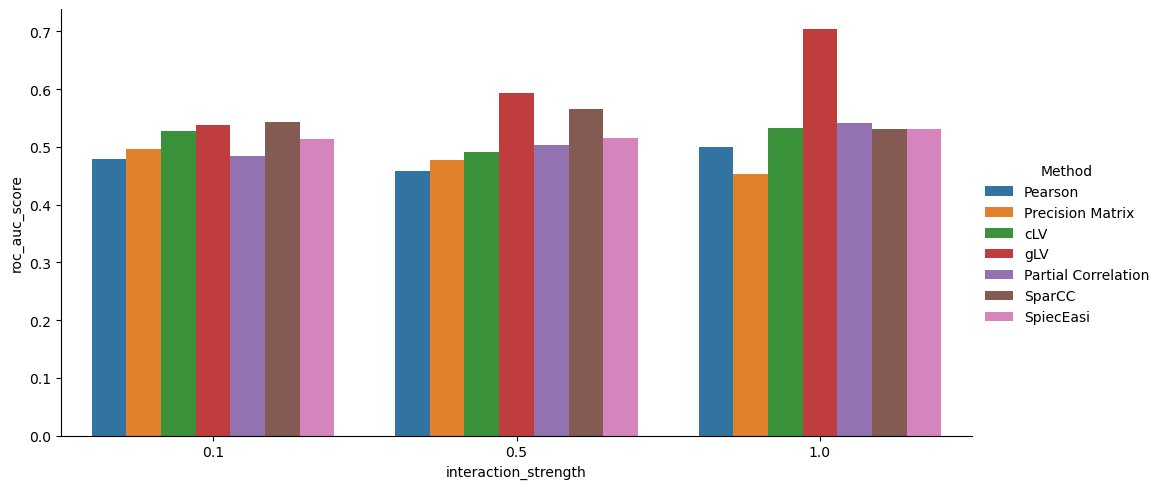

In [28]:
sns.catplot(data=result_df, x=var_for_test, y='roc_auc_score', hue='Method', kind='bar', height=5, aspect=2)
plt.savefig('docs/plots/roc_auc_interaction_strength.png')

We then test if the time interval can affect the result

In [31]:
%%capture
var_for_test = 'time_step'
result_df = pd.DataFrame(columns=['Method', 'average_precision_score', 'roc_auc_score', var_for_test])
var_time_step = [1e-2, 0.1, 0.5, 1]
for time_step in var_time_step:
    z, x, abd, adj, M = simulation.simulate_glv(num_taxa = n_vertices, avg_degree=avg_degree, time_points=1000, time_step=time_step, downsample=1, noise_var=0, max_interaction_strength=1)
    score_df = evaluation(adj, z, evaluation_func, metrics=metrics, verbose=False)
    score_df[var_for_test] = time_step
    result_df = result_df.append(score_df, ignore_index=True)

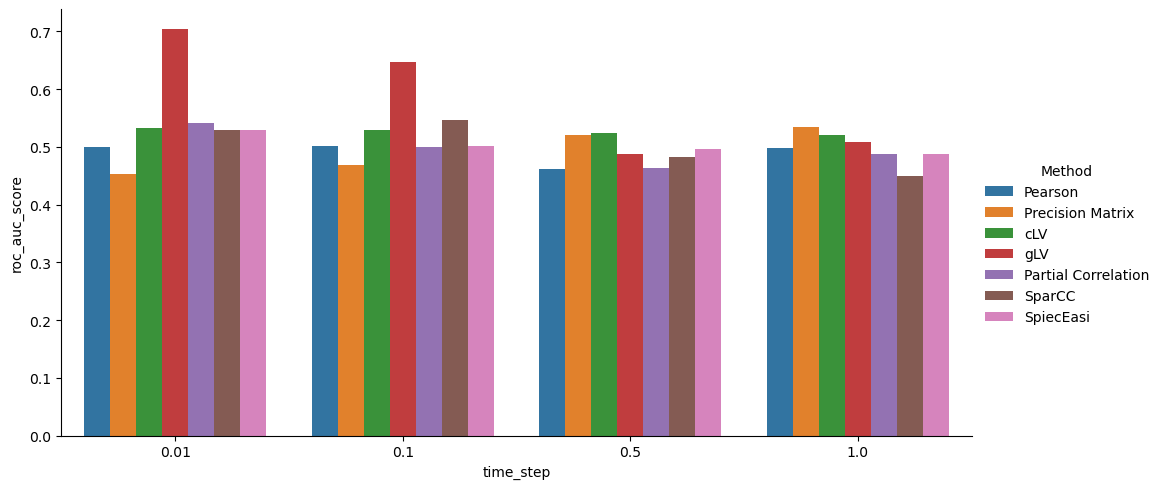

In [32]:
sns.catplot(data=result_df, x=var_for_test, y='roc_auc_score', hue='Method', kind='bar', height=5, aspect=2)
plt.savefig('docs/plots/roc_auc_time_step.png')

Then we test down sample rate

In [37]:
# %%capture
var_for_test = 'downsample'
result_df = pd.DataFrame(columns=['Method', 'average_precision_score', 'roc_auc_score', var_for_test])
var_downsample = [1, 2, 5, 10]
for downsample in var_downsample:
    z, x, abd, adj, M = simulation.simulate_glv(num_taxa = n_vertices, avg_degree=avg_degree, time_points=1000, time_step=1e-2, downsample=downsample, noise_var=0, max_interaction_strength=1)
    print(z.shape)
    score_df = evaluation(adj, z, evaluation_func, metrics=metrics, verbose=False)
    score_df[var_for_test] = downsample
    result_df = result_df.append(score_df, ignore_index=True)

Node 'mgx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:50    0:50
Added x0 vector to node mgx
Added growth rates to node mgx
Initialized
Interaction 'mgx_mgx' added
(1000, 50)
2.511722143213621e-05


R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done

C:\Users\dorasir\AppData\Local\Temp\ipykernel_14032\2835939298.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(score_df, ignore_index=True)


Node 'mgx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:50    0:50
Added x0 vector to node mgx
Added growth rates to node mgx
Initialized
Interaction 'mgx_mgx' added
(500, 50)
7.28673515769286e-05


R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done

C:\Users\dorasir\AppData\Local\Temp\ipykernel_14032\2835939298.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(score_df, ignore_index=True)


Node 'mgx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:50    0:50
Added x0 vector to node mgx
Added growth rates to node mgx
Initialized
Interaction 'mgx_mgx' added
(200, 50)
0.0003011617661502744


R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done

C:\Users\dorasir\AppData\Local\Temp\ipykernel_14032\2835939298.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(score_df, ignore_index=True)


Node 'mgx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:50    0:50
Added x0 vector to node mgx
Added growth rates to node mgx
Initialized
Interaction 'mgx_mgx' added
(100, 50)
0.000995409792083974


R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done

C:\Users\dorasir\AppData\Local\Temp\ipykernel_14032\2835939298.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(score_df, ignore_index=True)


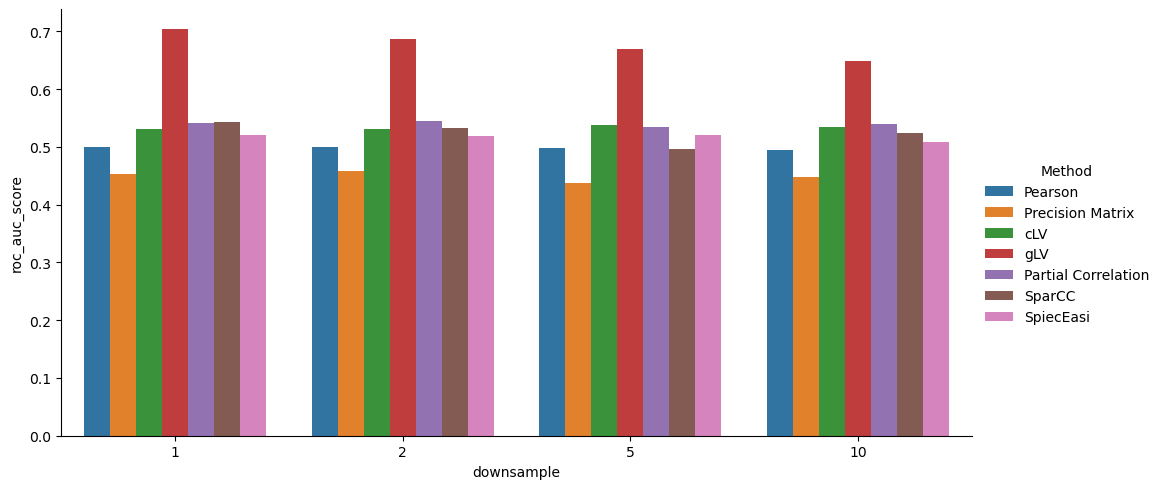

In [38]:
sns.catplot(data=result_df, x=var_for_test, y='roc_auc_score', hue='Method', kind='bar', height=5, aspect=2)
plt.savefig(f'docs/plots/roc_auc_{var_for_test}.png')

## Simulation of compositional data from MiSDEED

In [3]:
# Set up parameters
n_vertices = 50
avg_degree = 5
network_type = 'random'
interaction_type = 'random'
time_points = 1000
# time_step = 0.05
time_step = 1e-2
downsample = 1
noise_var = 1e-3

evaluation_func = [correlation_score, precision_matrix_score, clv_score, glv_score, pcor_score, sparcc_score, speic_score]
metrics = [average_precision_score, roc_auc_score]
# Define function for evaluation
def evaluation(adj, abundance, evaluation_func, metrics=average_precision_score, verbose=False):
    scores = []
    for func in evaluation_func:
        scores.append([func._method, *func(abundance, adj, metrics=metrics, verbose=verbose)])
    columns = ['Method']
    columns.extend([metric.__name__ for metric in metrics] if isinstance(metrics, List) else [metrics.__name__])
    scores_df = pd.DataFrame(scores, columns=columns)
    return scores_df

In [17]:
%%capture
result_df = pd.DataFrame(columns=['Method', 'average_precision_score', 'roc_auc_score', 'time_points'])
var_time_points = [100, 1000, 5000, 10000]
for t in var_time_points:
    z, x, abd, adj, M = simulation.simulate_glv(num_taxa = n_vertices, avg_degree=avg_degree, time_points=t, time_step=time_step, downsample=1, noise_var=0, max_interaction_strength=1)
    # x = clr_transform(x)
    score_df = evaluation(adj, x, evaluation_func, metrics=metrics, verbose=False)
    score_df['time_points'] = t
    result_df = result_df.append(score_df, ignore_index=True)

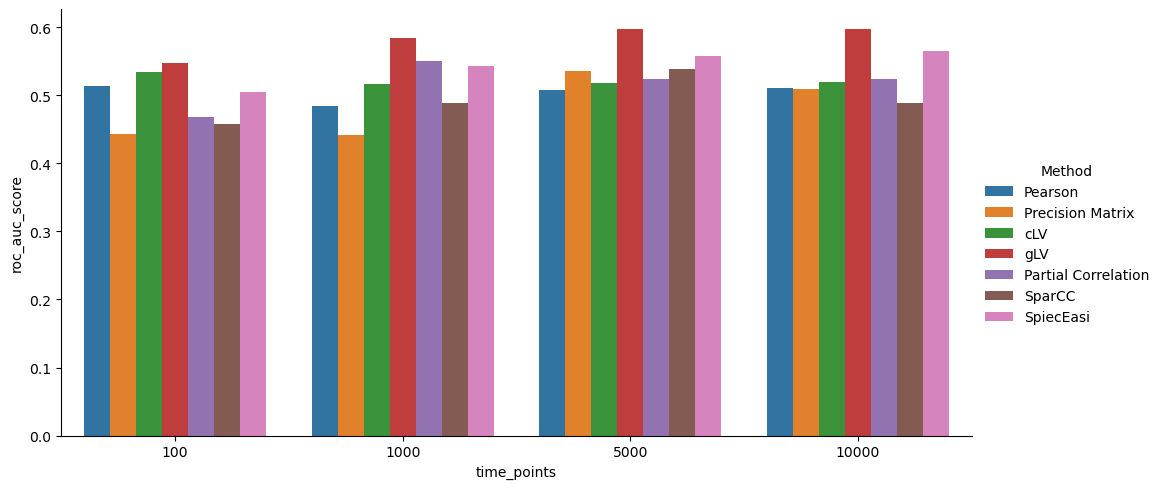

In [18]:
sns.catplot(data=result_df, x='time_points', y='roc_auc_score', hue='Method', kind='bar', height=5, aspect=2)